In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df=pd.read_csv('/content/covid19_tweets.csv')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [4]:
df.isnull().sum()

,0
user_name,0
user_location,36771
user_description,10286
user_created,0
user_followers,0
user_friends,0
user_favourites,0
user_verified,0
date,0
text,0


In [5]:
df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')

In [7]:
text_df = df.drop([
    'user_name', 'user_location', 'user_description', 'user_created',
    'user_followers', 'user_friends', 'user_favourites', 'user_verified',
    'date', 'hashtags', 'source', 'is_retweet'
], axis=1)


In [8]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0 

Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu 

@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3 

@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW 

25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 
@kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh 



In [9]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    179108 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB


In [10]:
#preprocessing
import nltk
def data_processing(text):
  text=text.lower()
  text=re.sub(r"https\S+|www\S+https\S+",'',text,flags=re.MULTILINE)
  text=re.sub(r'\@w+|\#','',text)
  text=re.sub (r'[^\w\s]','',text)
  text_tokens=word_tokenize(text)
  filtered_text=[w for w in text_tokens if not w in stop_words]
  return " ".join(filtered_text)

In [12]:
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
import nltk
nltk.download('punkt')
text_df.text = text_df['text'].apply(data_processing)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
text_df=text_df.drop_duplicates('text')

In [15]:
stemmer=PorterStemmer()
def stemming(data):
  text=[stemmer.stem(word) for word in data]
  return data

In [16]:
text_df['text']=text_df['text'].apply(lambda x:stemming(x))
text_df.head()

,text
0,smelled scent hand sanitizers today someone pa...
1,hey yankees yankeespr mlb wouldnt made sense p...
2,diane3443 dunlap realdonaldtrump trump never c...
3,brookbanktv one gift covid19 give appreciation...
4,25 july media bulletin novel coronavirusupdate...


In [17]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

smelled scent hand sanitizers today someone past would think intoxicated 

hey yankees yankeespr mlb wouldnt made sense players pay respects 

diane3443 dunlap realdonaldtrump trump never claimed covid19 hoax claim effort 

brookbanktv one gift covid19 give appreciation simple things always around 

25 july media bulletin novel coronavirusupdates covid19 kansalrohit69 drsyedsehrish airnewsalerts ani 



In [18]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166264 entries, 0 to 179107
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    166264 non-null  object
dtypes: object(1)
memory usage: 2.5+ MB


In [19]:
def polarity(text):
  return TextBlob(text).sentiment.polarity

In [20]:
text_df['polarity']=text_df['text'].apply(polarity)
text_df.head(10)

,text,polarity
0,smelled scent hand sanitizers today someone pa...,-0.25
1,hey yankees yankeespr mlb wouldnt made sense p...,0.00
2,diane3443 dunlap realdonaldtrump trump never c...,0.00
3,brookbanktv one gift covid19 give appreciation...,0.00
4,25 july media bulletin novel coronavirusupdate...,0.00
5,coronavirus covid19 deaths continue rise almos...,-0.70
6,covid19 change work general recruiting specifi...,0.05
7,wear face coverings shopping includes visit lo...,0.00
8,praying good health recovery chouhanshivraj co...,0.70
9,pope god prophet sadhu sundar selvaraj watch h...,0.00


In [21]:
def sentiment(label):
  if label <0:
    return "Negative"
  elif label==0:
    return "Neutral"
  elif label>0:
    return "Positive"

In [22]:
text_df['sentiment']=text_df['polarity'].apply(sentiment)
text_df.head()

,text,polarity,sentiment
0,smelled scent hand sanitizers today someone pa...,-0.25,Negative
1,hey yankees yankeespr mlb wouldnt made sense p...,0.00,Neutral
2,diane3443 dunlap realdonaldtrump trump never c...,0.00,Neutral
3,brookbanktv one gift covid19 give appreciation...,0.00,Neutral
4,25 july media bulletin novel coronavirusupdate...,0.00,Neutral


<Axes: xlabel='sentiment', ylabel='count'>

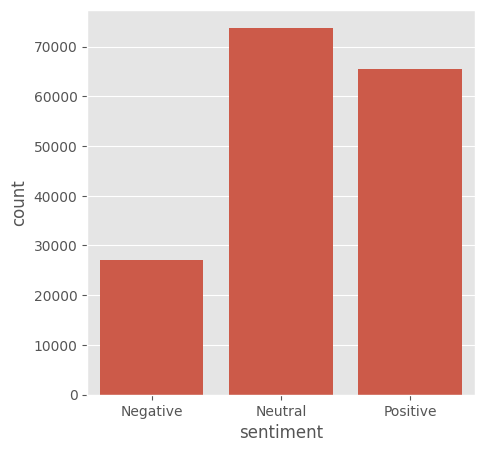

In [23]:
#visulaize
fig=plt.figure(figsize=(5,5))
sns.countplot(x='sentiment',data=text_df)

numpy.int64

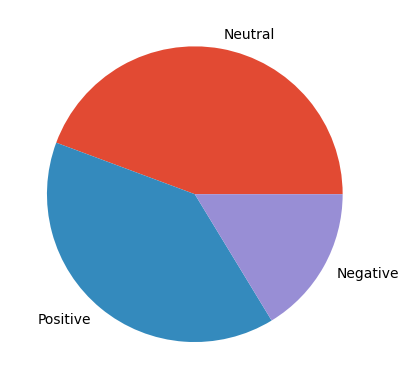

In [24]:
tags=text_df['sentiment'].value_counts()
plt.pie(tags.values,labels=tags.index)
type(tags.values[0])

In [25]:
pos_tweets=text_df[text_df.sentiment=='Positive']
pos_tweets=pos_tweets.sort_values(['polarity'],ascending=False)
pos_tweets.head()

,text,polarity,sentiment
179010,superb tony hasnt summer photos wonderful memo...,1.0,Positive
17921,border kitchen lesvos covid19 provides perfect...,1.0,Positive
17975,best work ay tried covid19,1.0,Positive
18025,best deal covid19,1.0,Positive
18144,believe team work stop covid19 arvindkejriwal ...,1.0,Positive


<function matplotlib.pyplot.show(close=None, block=None)>

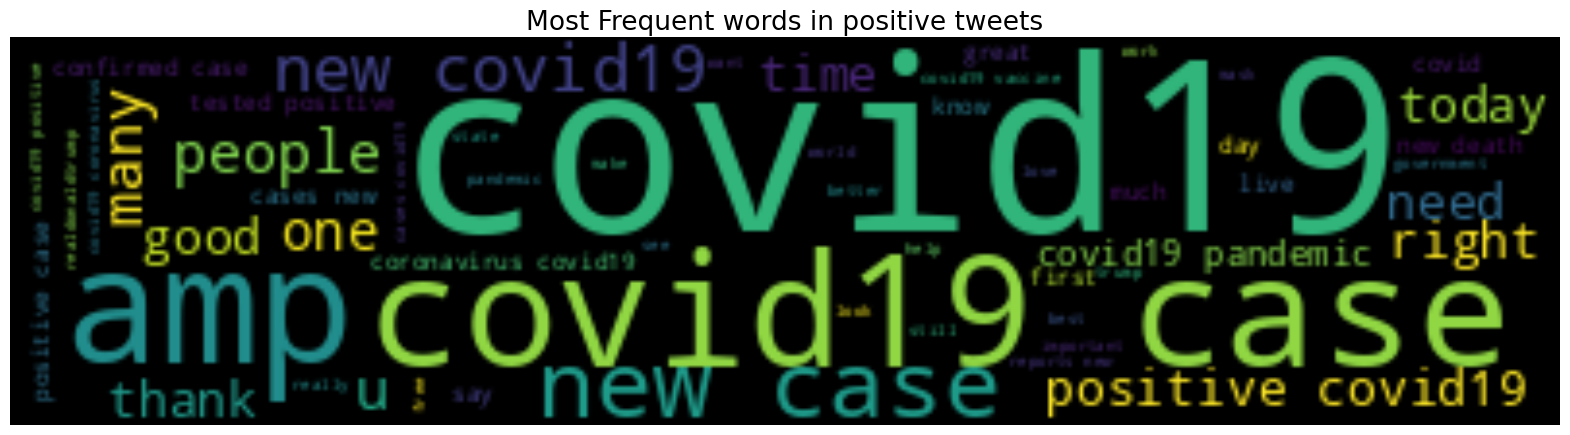

In [26]:
text=' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500,width=400,height=100).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent words in positive tweets',fontsize=19)
plt.show

In [27]:
neg_tweets=text_df[text_df.sentiment=='Negative']
neg_tweets=neg_tweets.sort_values(['polarity'],ascending=False)
neg_tweets.head()

,text,polarity,sentiment
15266,80k kids short sided choice slow economic reco...,-6.938894e-18,Negative
61329,covid19 proves childcare us broken fixed paren...,-9.251859e-18,Negative
145456,quarantine period might exhausting amp overwhe...,-9.251859e-18,Negative
129352,many people seen effects broken food supplycha...,-9.251859e-18,Negative
154577,actual fuck nygovcuomo book better colossal fu...,-1.110223e-17,Negative


<function matplotlib.pyplot.show(close=None, block=None)>

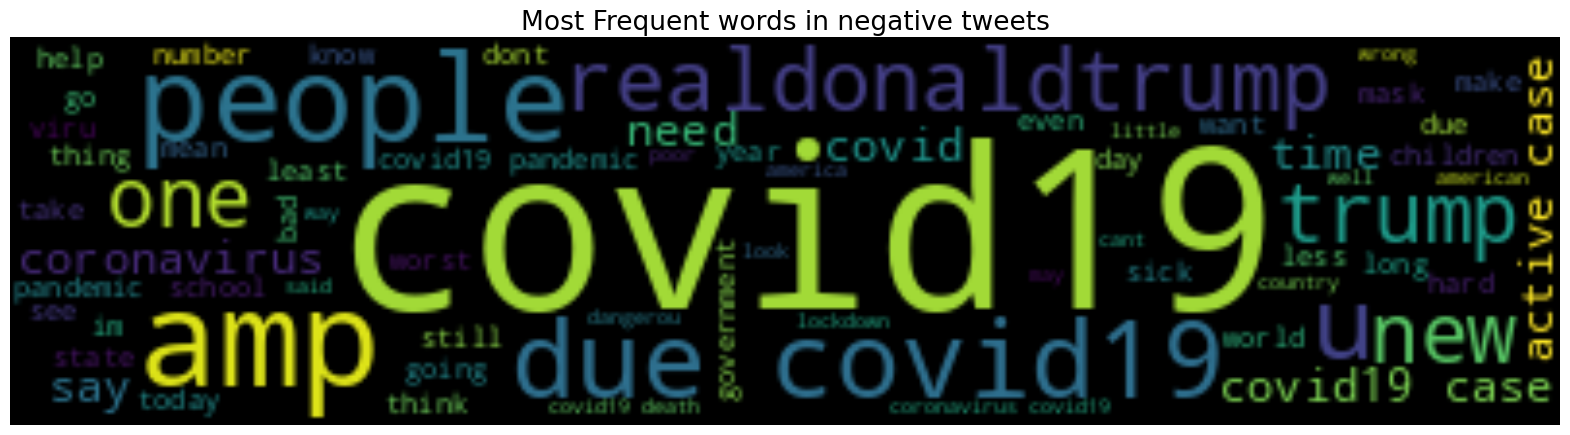

In [28]:
text=' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500,width=400,height=100).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent words in negative tweets',fontsize=19)
plt.show

In [29]:
neutral_tweets=text_df[text_df.sentiment=='Neutral']
neutral_tweets=neutral_tweets.sort_values(['polarity'],ascending=False)
neutral_tweets.head()

,text,polarity,sentiment
179107,stop see stop sabcnews izindabanews24 dailysun...,0.0,Neutral
1,hey yankees yankeespr mlb wouldnt made sense p...,0.0,Neutral
2,diane3443 dunlap realdonaldtrump trump never c...,0.0,Neutral
3,brookbanktv one gift covid19 give appreciation...,0.0,Neutral
4,25 july media bulletin novel coronavirusupdate...,0.0,Neutral


<function matplotlib.pyplot.show(close=None, block=None)>

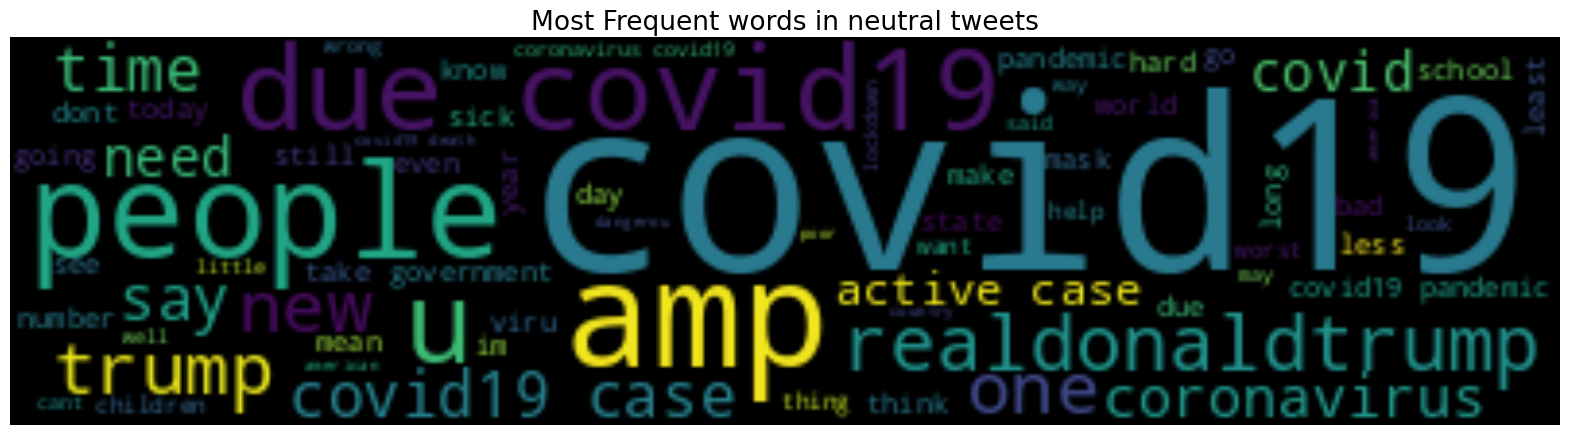

In [30]:
ext=' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500,width=400,height=100).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent words in neutral tweets',fontsize=19)
plt.show

In [31]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])


In [32]:
X= text_df['text']
Y= text_df['sentiment']
X=vect.transform(X)

In [33]:
x_train, x_test, y_train , y_test=train_test_split(X,Y, test_size=0.2, random_state=42)


In [34]:
print("size  of x_train: ",(x_train.shape))
print("size  of y_train: ",(y_train.shape))
print("size  of x_test: ",(x_test.shape))
print("size  of y_test: ",(y_test.shape))

size  of x_train:  (133011, 1130389)
size  of y_train:  (133011,)
size  of x_test:  (33253, 1130389)
size  of y_test:  (33253,)


In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
logreg= LogisticRegression()
logreg.fit(x_train,y_train)
logreg_pred= logreg.predict(x_test)
logreg_acc=accuracy_score(logreg_pred,y_test)
print("Accuracy:",logreg_acc*100)




Accuracy: 95.08916488737859


In [37]:
from sklearn.svm import LinearSVC

In [38]:
SVCmodel=LinearSVC()
SVCmodel.fit(x_train,y_train)

LinearSVC()

In [39]:
svc_pred= SVCmodel.predict(x_test)
svc_acc=accuracy_score(svc_pred,y_test)
print("test accuracy:" ,svc_acc*100)

test accuracy: 96.75818723122725
